# Library

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from IPython.display import clear_output
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from tensorflow.keras import layers, models, Input
from tensorflow.keras.applications import ResNet50
import matplotlib.patches as patches
from tensorflow.keras.applications import MobileNetV2
from tensorflow_examples.models.pix2pix import pix2pix


2025-06-16 09:57:00.517255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750067820.777285   25344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750067820.848534   25344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Function

## normalize

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

## load image

In [4]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (256, 256))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (256, 256),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## display

In [5]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

## resize bounding box

In [6]:
def bbox_resize(input_bbox, origin_size, target_size=(256, 256)):

    h_orig, w_orig = tf.cast(origin_size[0], tf.float32), tf.cast(origin_size[1], tf.float32)

    h_target, w_target = tf.cast(target_size[0], tf.float32), tf.cast(target_size[1], tf.float32)

    ymin, xmin, ymax, xmax = input_bbox[0], input_bbox[1], input_bbox[2], input_bbox[3]

    ymin_pixel = ymin * h_orig
    xmin_pixel = xmin * w_orig
    ymax_pixel = ymax * h_orig
    xmax_pixel = xmax * w_orig

    h_ratio = h_target / h_orig
    w_ratio = w_target / w_orig

    ymin_resized = ymin_pixel * h_ratio
    xmin_resized = xmin_pixel * w_ratio
    ymax_resized = ymax_pixel * h_ratio
    xmax_resized = xmax_pixel * w_ratio

    ymin_normalized = ymin_resized / h_target
    xmin_normalized = xmin_resized / w_target
    ymax_normalized = ymax_resized / h_target
    xmax_normalized = xmax_resized / w_target

    return tf.stack([ymin_normalized, xmin_normalized, ymax_normalized, xmax_normalized])

## load data for detection

In [7]:
def load_detection_data(datapoint, image_size=(256, 256)):
    origin_size = tf.shape(datapoint['image'])[:2]

    input_image = tf.image.resize(datapoint['image'], image_size)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    input_bbox = bbox_resize(datapoint['head_bbox'], origin_size, image_size)
    input_label = datapoint['label']

    return input_image, {'bbox': input_bbox, 'class': input_label}

## compute iou

In [8]:
def compute_iou(box1, box2):
    x1 = tf.maximum(box1[1], box2[1])
    y1 = tf.maximum(box1[0], box2[0])
    x2 = tf.minimum(box1[3], box2[3])
    y2 = tf.minimum(box1[2], box2[2])

    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union = box1_area + box2_area - intersection

    return intersection / (union + 1e-6)

## display bbox with 1 image

In [10]:
def display_bbox_single(img, bbox_true, label_true, model, id2label):
    if hasattr(label_true, 'numpy'):
        label_true = label_true.numpy()

    img_np = img.numpy()
    h, w = img_np.shape[:2]

    img_resized = tf.image.resize(img, (256, 256))
    img_resized = tf.expand_dims(img_resized, axis=0)

    pred_bbox, pred_class = model.predict(img_resized, verbose=0)
    pred_bbox = pred_bbox[0]
    pred_label = np.argmax(pred_class[0])

    ymin_pred = int(pred_bbox[0] * h)
    xmin_pred = int(pred_bbox[1] * w)
    ymax_pred = int(pred_bbox[2] * h)
    xmax_pred = int(pred_bbox[3] * w)

    ymin_true = int(bbox_true[0] * h)
    xmin_true = int(bbox_true[1] * w)
    ymax_true = int(bbox_true[2] * h)
    xmax_true = int(bbox_true[3] * w)

    iou = compute_iou_task_4(
    tf.constant([ymin_true, xmin_true, ymax_true, xmax_true], dtype=tf.float32),
    tf.constant([ymin_pred, xmin_pred, ymax_pred, xmax_pred], dtype=tf.float32)).numpy()

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img_np)
    ax.axis('off')

    #Ground Truth
    rect_true = patches.Rectangle(
        (xmin_true, ymin_true), xmax_true - xmin_true, ymax_true - ymin_true,
        linewidth=2, edgecolor='red', facecolor='none', label='Ground Truth'
    )
    ax.add_patch(rect_true)

    #Predicted
    rect_pred = patches.Rectangle(
        (xmin_pred, ymin_pred), xmax_pred - xmin_pred, ymax_pred - ymin_pred,
        linewidth=2, edgecolor='lime', facecolor='none', label='Predicted'
    )
    ax.add_patch(rect_pred)

    true_name = id2label[label_true]
    pred_name = id2label[pred_label]
    ax.set_title(f"True: {true_name} | Pred: {pred_name} | IoU: {iou:.2f}", fontsize=14)
    ax.legend(loc='upper right')
    plt.show()


## plot training curve

In [11]:
def plot_training_curve(history_model):
    hist = history_model.history
    epochs = range(1, len(hist['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['loss'], label='Train Total Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['class_loss'], label='Train Class Loss')
    plt.plot(epochs, hist['val_class_loss'], label='Val Class Loss')
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['bbox_loss'], label='Train BBox Loss')
    plt.plot(epochs, hist['val_bbox_loss'], label='Val BBox Loss')
    plt.title('Bounding Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['class_accuracy'], label='Train Class Accuracy')
    plt.plot(epochs, hist['val_class_accuracy'], label='Val Class Accuracy')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

## display test evaluation

In [12]:
def display_test_result(image, true_bbox, true_class, model, id2label):
    # Dự đoán bbox
    pred_bbox = model.predict(tf.expand_dims(image, axis=0))[0]

    # Chuẩn hoá bbox thành shape (4,)
    true_bbox = np.squeeze(true_bbox)
    pred_bbox = np.squeeze(pred_bbox)

    if true_bbox.shape != (4,) or pred_bbox.shape != (4,):
        print("wrong shape:", true_bbox.shape, pred_bbox.shape)
        return

    # Tính IoU
    iou = compute_iou(true_bbox, pred_bbox)
    true_label = id2label[int(true_class)]

    # Vẽ hình ảnh + BBox
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.imshow(image)
    ax.set_title(f"True: {true_label} | IoU: {iou:.2f}", fontsize=14)

    h, w = image.shape[:2]

    # Vẽ bbox ground truth (màu xanh)
    y_min, x_min, y_max, x_max = true_bbox
    rect_gt = plt.Rectangle((x_min * w, y_min * h),
                            (x_max - x_min) * w, (y_max - y_min) * h,
                            fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect_gt)

    # Vẽ bbox dự đoán (màu đỏ, nét đứt)
    y_min, x_min, y_max, x_max = pred_bbox
    rect_pred = plt.Rectangle((x_min * w, y_min * h),
                              (x_max - x_min) * w, (y_max - y_min) * h,
                              fill=False, edgecolor='red', linewidth=2, linestyle='dashed')
    ax.add_patch(rect_pred)

    pred_output = model.predict(tf.expand_dims(image, axis=0))
    pred_bbox = np.squeeze(pred_output[0])
    pred_class = np.argmax(pred_output[1]) if isinstance(pred_output, (list, tuple)) else None
    pred_label = id2label.get(pred_class, "Unknown") if pred_class is not None else "?"

    ax.set_title(f"True: {true_label} | Pred: {pred_label} | IoU: {iou:.2f}", fontsize=14)
    plt.axis('off')
    plt.show()


## create mask

In [13]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1) 
    return pred_mask

## load data in segmentation

In [14]:
def load_segmentation_data(sample):
    image = tf.image.resize(sample['image'], (256, 256)) / 255.0
    mask = tf.image.resize(tf.cast(sample['segmentation_mask'], tf.float32), (256, 256))
    return image, mask

## visualize segmentation

In [15]:
def show_prediction(image, true_mask, pred_mask):
    plt.figure(figsize=(12, 4))

    titles = ['Image', 'Ground Truth Mask', 'Predicted Mask']
    display_list = [image, true_mask, pred_mask]

    for i in range(3):
        plt.subplot(1, 3, i+1)
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(display_list[i], cmap='gray', vmin=0, vmax=2)
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## display test in segmentation

In [16]:
def display_segmentation_result(image, true_mask, pred_mask):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image)
    axes[0].set_title("Input Image")
    axes[0].axis('off')

    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


## Plot task 4

In [19]:
def plot_multi_task(history_model):
    hist = history_model.history
    epochs = range(1, len(hist['loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['loss'], label='Train Total Loss')
    plt.plot(epochs, hist['val_loss'], label='Val Total Loss')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['class_loss'], label='Train Classification Loss')
    plt.plot(epochs, hist['val_class_loss'], label='Val Classification Loss')
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['head_bbox_loss'], label='Train BBox Loss')
    plt.plot(epochs, hist['val_head_bbox_loss'], label='Val BBox Loss')
    plt.title('Bounding Box Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['segmentation_mask_loss'], label='Train Segmentation Loss')
    plt.plot(epochs, hist['val_segmentation_mask_loss'], label='Val Segmentation Loss')
    plt.title('Segmentation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['class_accuracy'], label='Train Classification Accuracy')
    plt.plot(epochs, hist['val_class_accuracy'], label='Val Classification Accuracy')
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, hist['segmentation_mask_accuracy'], label='Train Segmentation Accuracy')
    plt.plot(epochs, hist['val_segmentation_mask_accuracy'], label='Val Segmentation Accuracy')
    plt.title('Segmentation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


# Task 1: Dataset Exploration and Preprocessing

In [20]:
ds_full, ds_info = tfds.load(
    "oxford_iiit_pet",
    split="train",
    with_info=True,
    as_supervised=False
)

# Chia train/test theo đề bài
total_count = 3680
test_ratio = 0.2
test_count = int(total_count * test_ratio)   # 736
train_count = total_count - test_count       # 2944

ds_train = ds_full.take(train_count)         # 2944 ảnh đầu
ds_test = ds_full.skip(train_count) 

I0000 00:00:1750067830.080449   25344 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [21]:
val_ratio = 0.2
val_count = int(train_count * val_ratio)      
train_final_count = train_count - val_count   

ds_train_final = ds_train.take(train_final_count)
ds_val = ds_train.skip(train_final_count)

In [22]:
len(ds_train), len(ds_val), len(ds_test)

(2944, 588, 736)

In [23]:
print(ds_info.features)
print(ds_info.features['label'].names)

FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [24]:
for example in ds_train.take(1):
    image = example['image'].shape
    label = example['label'].shape
    bbox = example['head_bbox']
    print(image, label,bbox)

(500, 500, 3) () tf.Tensor([0.154 0.178 0.53  0.566], shape=(4,), dtype=float32)


In [25]:
print(ds_info.splits['train'].num_examples)

3680


# Data Agumentation

In [26]:
TRAIN_LENGTH = ds_info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [27]:
train_images = ds_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images = ds_val.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = ds_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))
val_batches = val_images.batch(BATCH_SIZE)
test_batches = test_images.batch(BATCH_SIZE)

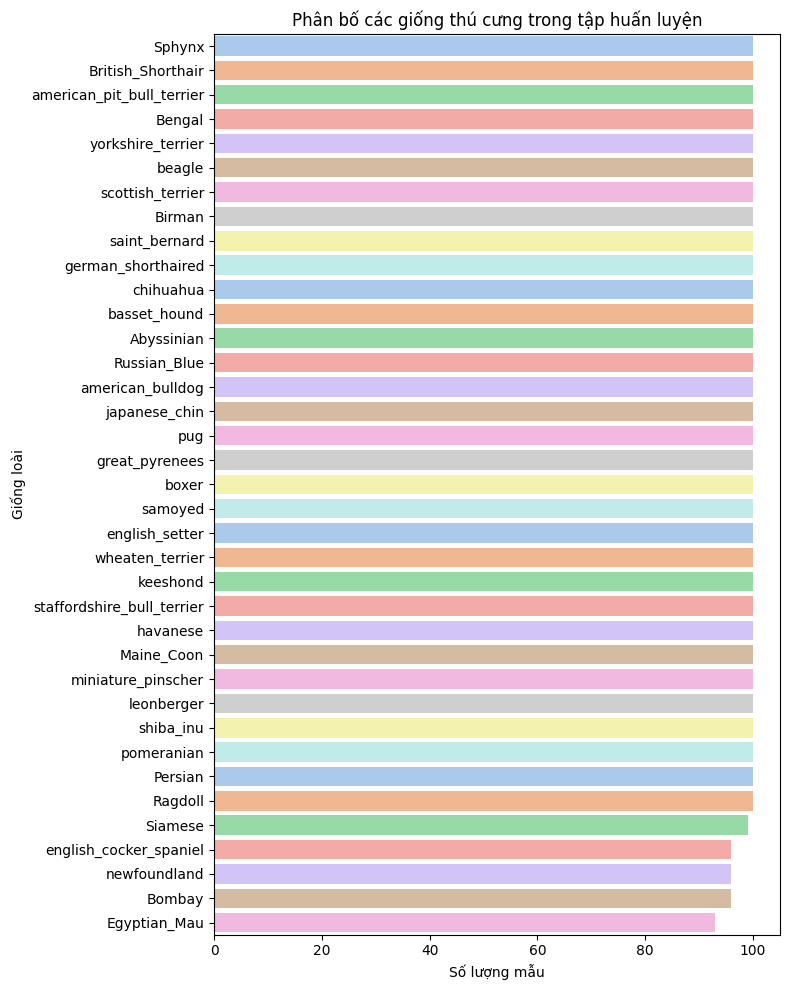

In [29]:
_, info = tfds.load("oxford_iiit_pet", with_info=True)
breed_names = info.features['label'].names
train_data = tfds.load("oxford_iiit_pet", split="train", as_supervised=False)
train_data = list(tfds.as_numpy(train_data))

labels = [example['label'] for example in train_data]

df_labels = pd.DataFrame(labels, columns=['label'])
df_labels['breed'] = df_labels['label'].apply(lambda x: breed_names[x])

plt.figure(figsize=(8, 10))
sns.countplot(data=df_labels, y='breed', palette='pastel',
              order=df_labels['breed'].value_counts().index)
plt.title("Phân bố các giống thú cưng trong tập huấn luyện")
plt.xlabel("Số lượng mẫu")
plt.ylabel("Giống loài")
plt.tight_layout()
plt.show()

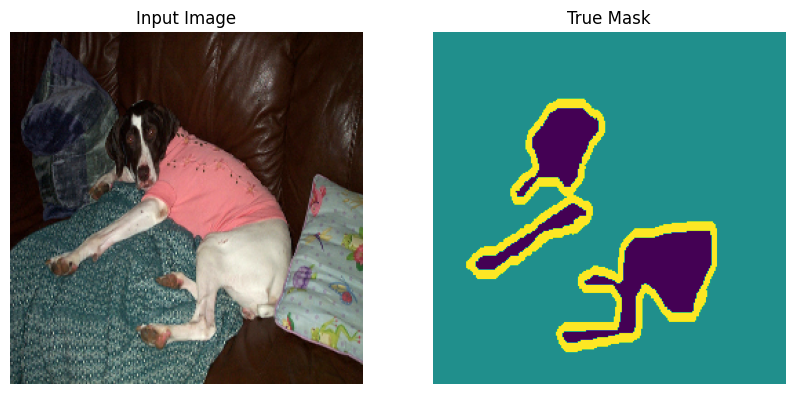

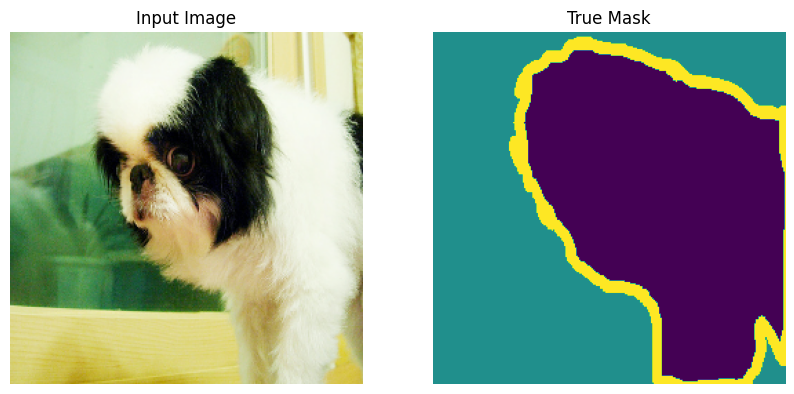

In [30]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# Task 2: Object Detection

In [31]:
BATCH_SIZE = 32

In [32]:
for example in ds_train.take(1):
    print(example.keys())

dict_keys(['file_name', 'head_bbox', 'image', 'label', 'segmentation_mask', 'species'])


In [33]:
labels = ds_info.features['label'].names

label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

In [34]:
detection_train_data = ds_train.map(load_detection_data, num_parallel_calls=tf.data.AUTOTUNE)
detection_val_data   = ds_val.map(load_detection_data, num_parallel_calls=tf.data.AUTOTUNE)

In [35]:
detection_train_batches = (
    detection_train_data
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
detection_val_batches = (
    detection_val_data
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


## Without pre-trained weights: Using Resnet50

In [36]:
def object_detection(input_shape=(256, 256, 3), num_classes=37, pretrained=True, freeze_backbone=False):
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet' if pretrained else None
    )
    base_model.trainable = not freeze_backbone

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=True)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x_flat = tf.keras.layers.Flatten()(x)

    # Branch for bbox regression
    bbox_output = tf.keras.layers.Dense(256, activation='relu')(x_flat)
    bbox_output = tf.keras.layers.Dense(128, activation='relu')(bbox_output)
    bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox')(bbox_output)

    # Branch for classification
    cls_x = tf.keras.layers.Dense(256, activation='relu')(x_flat)
    cls_x = tf.keras.layers.Dropout(0.5)(cls_x)
    cls_x = tf.keras.layers.Dense(128, activation='relu')(cls_x)
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(cls_x)

    return tf.keras.Model(inputs=inputs, outputs=(bbox_output, class_output))


In [37]:
resnet50 = object_detection(pretrained=False, freeze_backbone = True)
resnet50.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 8, 8, 256)      │      4,718,848 │ resnet50[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 128)      │        295,040 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 8192)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 256)            │      2,097,408 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │      2,097,408 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bbox (Dense)              │ (None, 4)              │            516 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ class (Dense)             │ (None, 37)             │          4,773 │ dense_3[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 32,867,497 (125.38 MB)

 Trainable params: 9,279,785 (35.40 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
resnet50.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=['mse', 'sparse_categorical_crossentropy'],
    metrics=['mae', 'accuracy']
)


# Callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2,
                                                  min_delta=1e-3,verbose=1)

Resnet50 = resnet50.fit(
    detection_train_batches,
    validation_data=detection_val_batches,
    epochs=100,
    steps_per_epoch=100,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/100


I0000 00:00:1750067854.722587   25429 service.cc:148] XLA service 0x7cb31800dfb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750067854.724912   25429 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750067856.497598   25429 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/100 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - bbox_loss: 0.0703 - bbox_mae: 0.2245 - class_accuracy: 0.0703 - class_loss: 3.6134 - loss: 3.6837  

I0000 00:00:1750067862.716324   25429 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 199ms/step - bbox_loss: 0.0338 - bbox_mae: 0.1463 - class_accuracy: 0.0280 - class_loss: 3.6195 - loss: 3.6534 - val_bbox_loss: 0.0230 - val_bbox_mae: 0.1219 - val_class_accuracy: 0.0306 - val_class_loss: 3.6090 - val_loss: 3.6322 - learning_rate: 1.0000e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - bbox_loss: 0.0245 - bbox_mae: 0.1239 - class_accuracy: 0.0242 - class_loss: 3.6105 - loss: 3.6350 - val_bbox_loss: 0.0227 - val_bbox_mae: 0.1189 - val_class_accuracy: 0.0221 - val_class_loss: 3.6089 - val_loss: 3.6320 - learning_rate: 1.0000e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - bbox_loss: 0.0237 - bbox_mae: 0.1221 - class_accuracy: 0.0312 - class_loss: 3.6092 - loss: 3.6329 - val_bbox_loss: 0.0219 - val_bbox_mae: 0.1174 - val_class_accuracy: 0.0510 - val_class_loss: 3.6033 - val_loss: 3.6257 - learning_rate: 1.0000e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - bbox_loss: 0.0222 - bbox_mae: 0.1179 - cla

In [39]:
resnet50.save("resnet50_model.keras")

## Visualization 

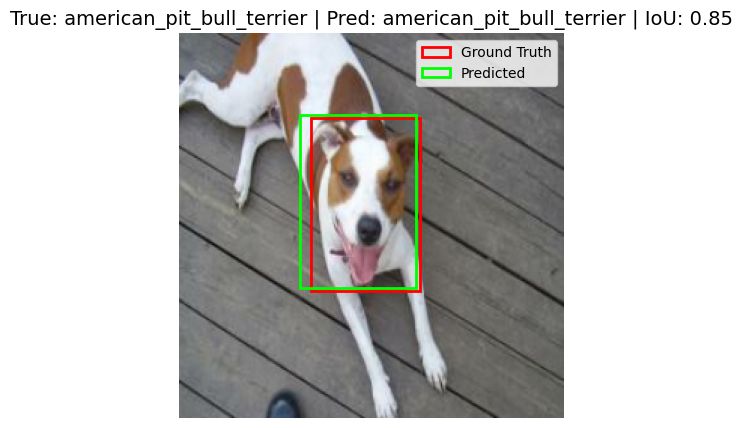

In [40]:
index=10
for images, targets in detection_val_batches.take(1):
    display_bbox_single(
        img=images[index],
        bbox_true=targets['bbox'][index],
        label_true=targets['class'][index],
        model=resnet50,
        id2label=id2label)

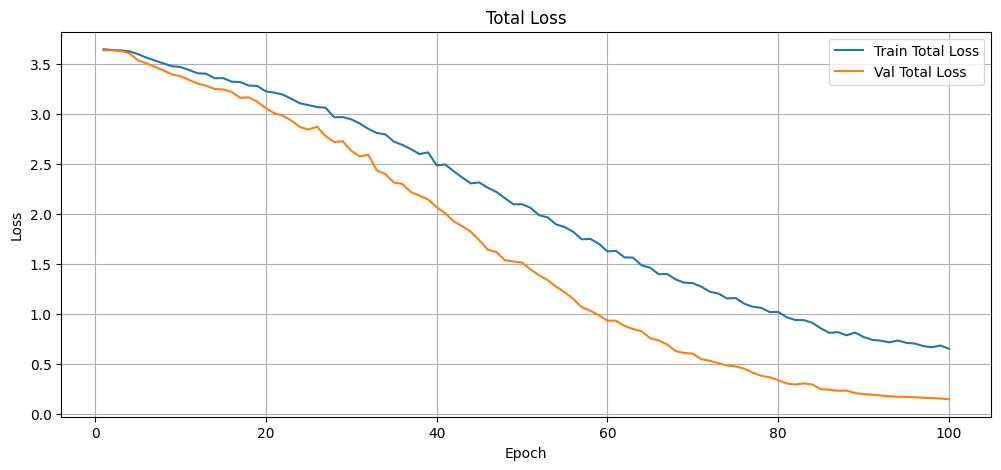

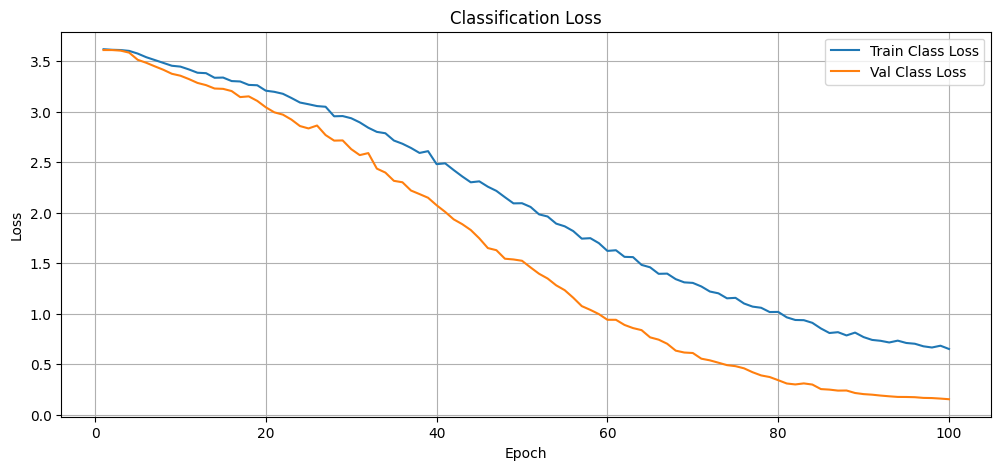

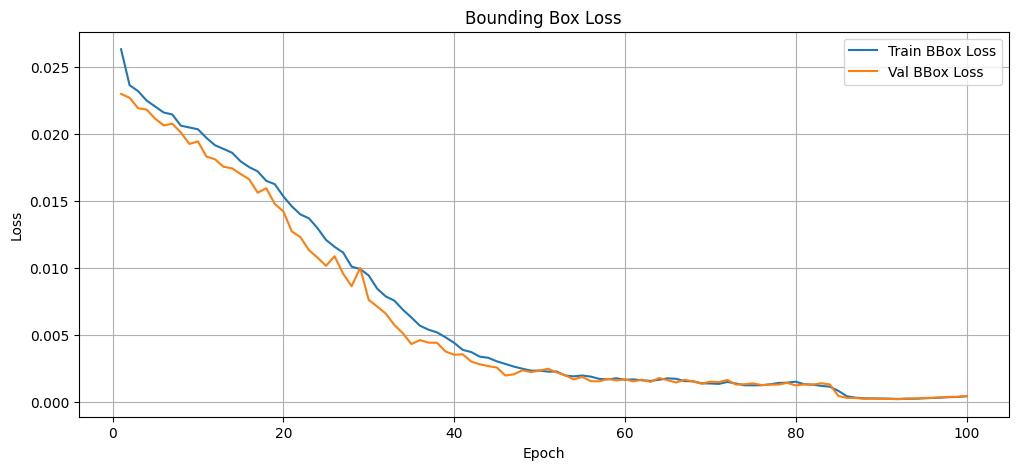

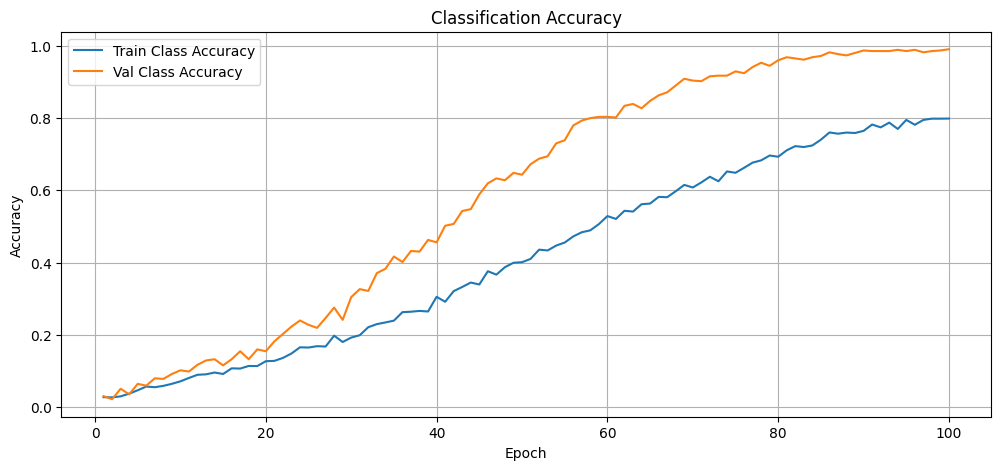

In [41]:
plot_training_curve(history_model=Resnet50)

## Test Evaluation 

In [42]:
test_count = int(total_count * test_ratio)   
train_count = total_count - test_count       

train = ds_full.take(train_count)         
test = ds_full.skip(train_count)          

In [43]:
ds_train_full = ds_train.map(load_detection_data, num_parallel_calls=tf.data.AUTOTUNE)

val_size = int(0.2 * 3680)
detection_test_dataset = ds_train_full.take(val_size)

BATCH_SIZE = 32
detection_test_batches = detection_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


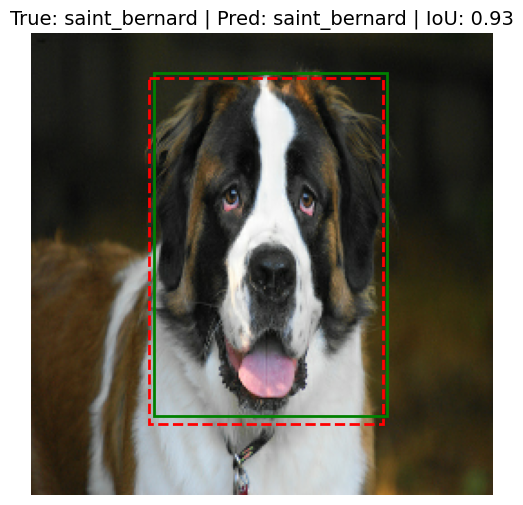

In [44]:
model = tf.keras.models.load_model("resnet50_model.keras", compile=False)

all_images = []
all_bboxes = []
all_classes = []

for img_batch, lbl_batch in detection_test_batches:
    for img, bbox, cls in zip(img_batch, lbl_batch['bbox'], lbl_batch['class']):
        all_images.append(img)
        all_bboxes.append(bbox)
        all_classes.append(cls)
i = 20
image = all_images[i]
bbox = all_bboxes[i]
cls = all_classes[i]
display_test_result(image, bbox, cls, model=model, id2label=id2label)

## With pre-trained weights: Using Resnet50

In [45]:
resnet50_pretrain_v2 = object_detection(pretrained=True, freeze_backbone = False)
resnet50_pretrain_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=['mse', 'sparse_categorical_crossentropy'],
    metrics=['mae', 'accuracy'])

# Callback
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=2,
                                                  min_delta=1e-3,verbose=1)

Resnet50_pretrain_v2=resnet50_pretrain_v2.fit(
    detection_train_batches,
    validation_data=detection_val_batches,
    epochs=50,
    steps_per_epoch=100,
    callbacks=[early_stop, lr_schedule])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 104s 295ms/step - bbox_loss: 0.0261 - bbox_mae: 0.1224 - class_accuracy: 0.0591 - class_loss: 3.7482 - loss: 3.7743 - val_bbox_loss: 0.0334 - val_bbox_mae: 0.1419 - val_class_accuracy: 0.0374 - val_class_loss: 3.8020 - val_loss: 3.8263 - learning_rate: 1.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - bbox_loss: 0.0125 - bbox_mae: 0.0858 - class_accuracy: 0.4051 - class_loss: 2.0154 - loss: 2.0279 - val_bbox_loss: 0.0352 - val_bbox_mae: 0.1559 - val_class_accuracy: 0.0221 - val_class_loss: 3.9933 - val_loss: 4.0106 - learning_rate: 1.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 234ms/step - bbox_loss: 0.0099 - bbox_mae: 0.0768 - class_accuracy: 0.7009 - class_loss: 1.0246 - loss: 1.0346 - val_bbox_loss: 0.0290 - val_bbox_mae: 0.1407 - val_class_accuracy: 0.0289 - val_class_loss: 3.7538 - val_loss: 3.7711 - learning_rate: 1.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step - bbox_loss: 0.0095 - bbox_mae: 0.0

In [46]:
resnet50_pretrain_v2.save("resnet50_pretrain2_model.keras")

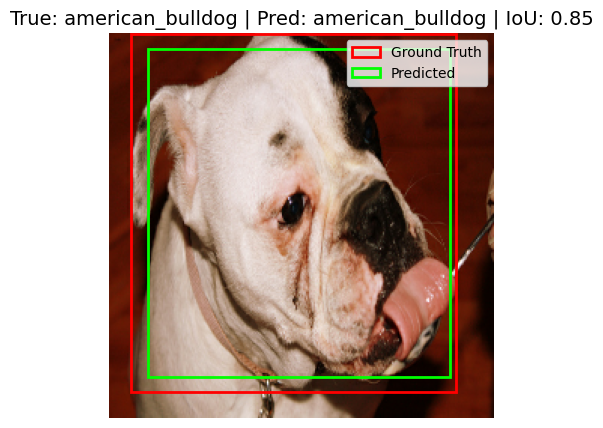

In [47]:
index=20
for images, targets in detection_val_batches.take(1):
    display_bbox_single(
        img=images[index],
        bbox_true=targets['bbox'][index],
        label_true=targets['class'][index],
        model=resnet50_pretrain_v2,
        id2label=id2label)

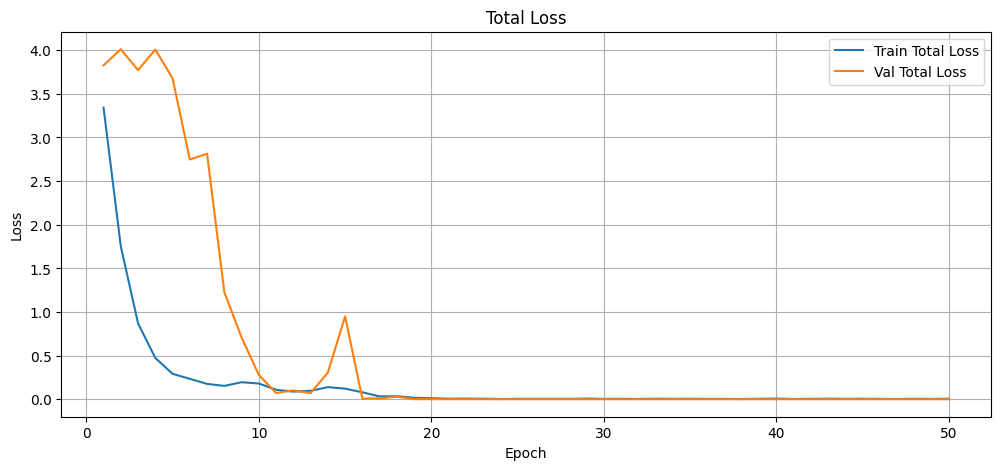

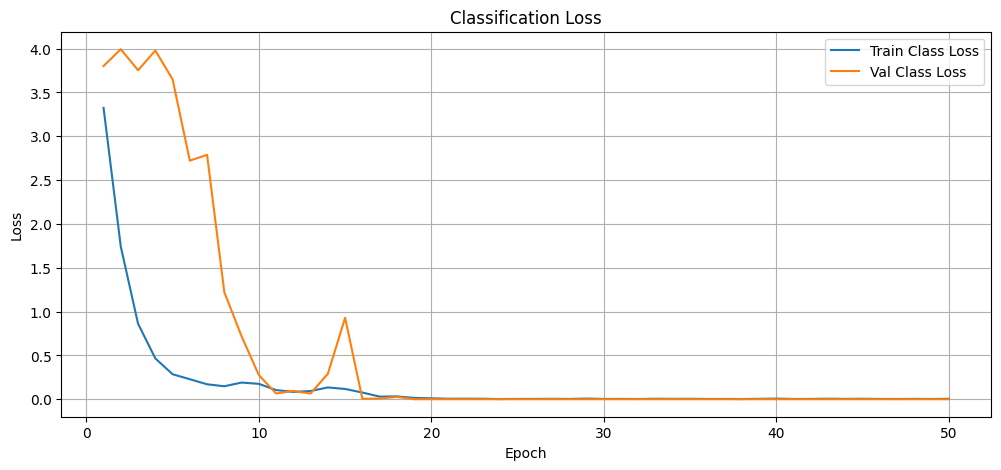

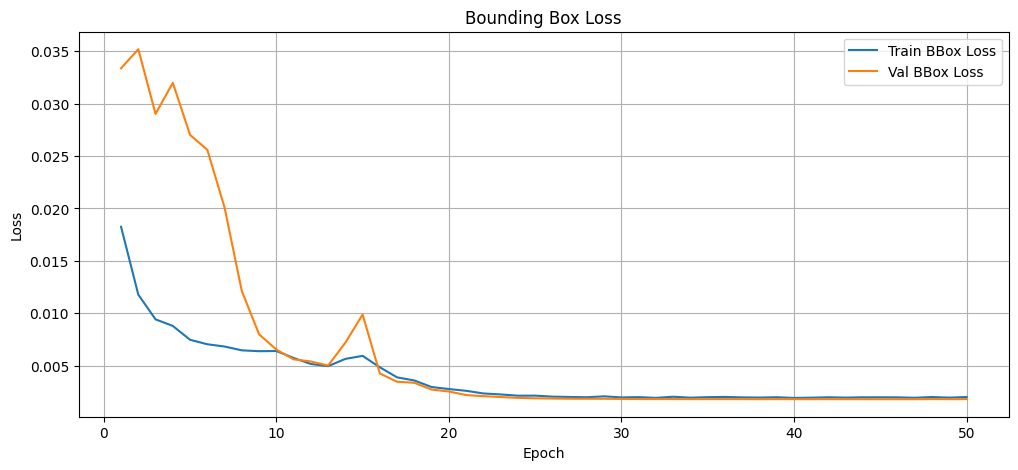

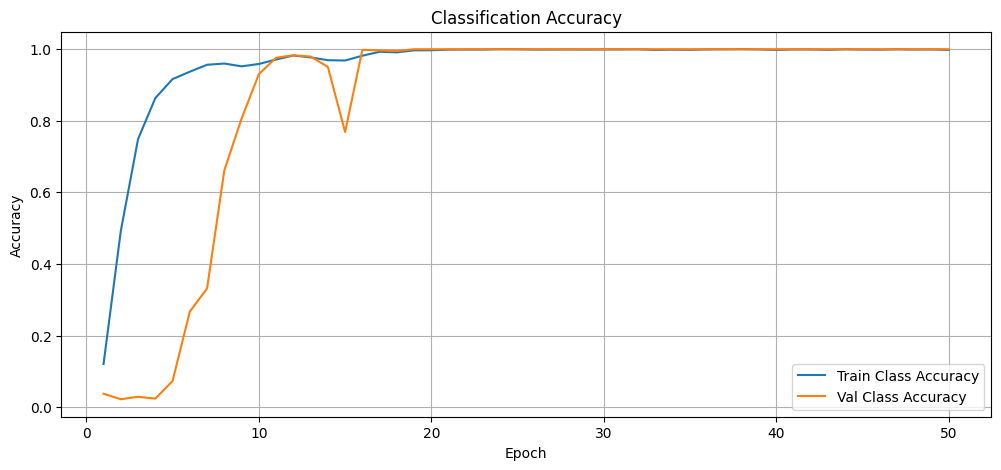

In [48]:
plot_training_curve(history_model=Resnet50_pretrain_v2)

## Test Evaluation for pre-train weights

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


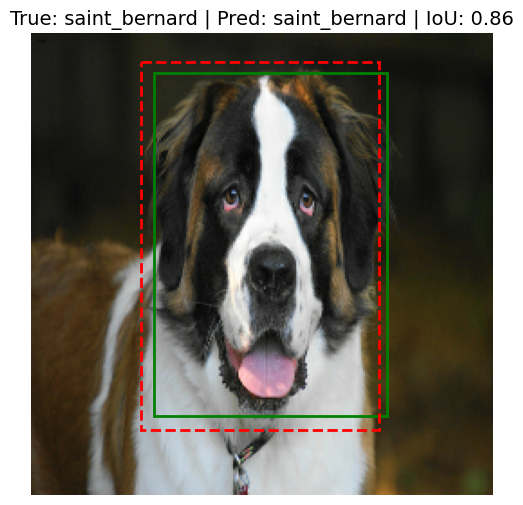

In [49]:
model = tf.keras.models.load_model("resnet50_pretrain2_model.keras", compile=False)

all_images = []
all_bboxes = []
all_classes = []

for img_batch, lbl_batch in detection_test_batches:
    for img, bbox, cls in zip(img_batch, lbl_batch['bbox'], lbl_batch['class']):
        all_images.append(img)
        all_bboxes.append(bbox)
        all_classes.append(cls)
i = 20
image = all_images[i]
bbox = all_bboxes[i]
cls = all_classes[i]
display_test_result(image, bbox, cls, model=model, id2label=id2label)

## Question
Answer the following questions (Q1) in your report: 
* Which model performed better overall?


**Answer:** Models using pre-trained weights give better results, with less overfitting.
  
* Were there any signs of overfitting or underfitting in either model?

**Answer:** The non-pre-trained model shows signs of overfitting, which is corrected by dropout and data augmentation.

* How did you address them? How did the bounding box MAE and IoU values compare across models?

**Answer:** The MAE and IoU of the pre-trained model are superior.
  

In [50]:
ious = []
for image, label in val_dataset.take(50):  
    pred_bbox = model.predict(tf.expand_dims(image, axis=0))[0]
    true_bbox = label['bbox'].numpy()
    iou = compute_iou(true_bbox, pred_bbox).numpy()
    ious.append(iou)

print("Average IoU:", np.mean(ious))

NameError: name 'val_dataset' is not defined

In [ ]:
maes = []
for image, label in val_dataset.take(50):
    pred_bbox = model.predict(tf.expand_dims(image, axis=0))[0]
    true_bbox = label['bbox'].numpy()
    mae = np.mean(np.abs(true_bbox - pred_bbox))
    maes.append(mae)

print("Average MAE:", np.mean(maes))

# Task 3: Semantic Segmentation

In [ ]:
segmentation_train_data = train_images.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
segmentation_val_data = val_images.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
segmentation_test_data = test_images.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches_segment = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(32)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))
val_batches_segment = val_images.batch(16)

## Without pre-trained weights: Using MobileNetV2

In [ ]:
def semantic_segmentation(input_shape=(256, 256, 3), num_classes=3, include_weights=True):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                include_top=False, weights='imagenet' if include_weights else None)

    layer_names = [
        'block_1_expand_relu',   
        'block_3_expand_relu',   
        'block_6_expand_relu',   
        'block_13_expand_relu',  
        'block_16_project',       
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    down_stack.trainable = False    

    up_stack = [
        pix2pix.upsample(512, 3),  
        pix2pix.upsample(256, 3),  
        pix2pix.upsample(128, 3),  
        pix2pix.upsample(64, 3),
    ]

    inputs = tf.keras.layers.Input(shape=input_shape)
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
        filters=num_classes, kernel_size=3, strides=2,
        padding='same'
    )
    x = last(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


In [ ]:
mobilenetV2 = semantic_segmentation(num_classes=3, include_weights=False)
mobilenetV2.summary()

In [ ]:
mobilenetV2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

MobilenetV2 = mobilenetV2.fit(
    segmentation_train_data,
    validation_data=segmentation_val_data,
    epochs=50,
    steps_per_epoch=100,
    callbacks=[early_stop, lr_schedule])

In [ ]:
mobilenetV2.save("mobilenetV2.keras")

In [ ]:
index = 1
for image_batch, mask_batch in val_batches_segment.take(1):
    sample_image = image_batch[index]
    sample_mask = mask_batch[index]

    pred_logits = mobilenetV2.predict(tf.expand_dims(sample_image, axis=0))[0]  # (H, W, num_classes)
    pred_mask = tf.argmax(pred_logits, axis=-1)  # (H, W)
    pred_mask = tf.squeeze(pred_mask)
    show_prediction(sample_image, sample_mask, pred_mask)

## Test evaluation

In [ ]:
ds_train_full = ds_train.map(load_segmentation_data, num_parallel_calls=tf.data.AUTOTUNE)

test_size = int(0.2 * 3680)
ds_test_segment = ds_train_full.take(test_size)
ds_train_segment = ds_train_full.skip(test_size)

test_batches_segment = ds_test_segment.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for img_batch, mask_batch in test_batches_segment.take(1):
    print("Image shape:", img_batch.shape)       # (batch_size, 256, 256, 3)
    print("Mask shape:", mask_batch.shape)

In [ ]:
MobilenetV2 = tf.keras.models.load_model("mobilenetV2.keras", compile=False)

image = img_batch[0]
true_mask = mask_batch[0]

pred_mask = MobilenetV2.predict(tf.expand_dims(image, axis=0))[0]
pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = tf.squeeze(pred_mask)

display_segmentation_result(image, true_mask, pred_mask)

## With pre-trained weights: Using MobileNetV2

In [ ]:
mobilenetV2_pretrain = semantic_segmentation(num_classes=3, include_weights=True)

mobilenetV2_pretrain.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

MobilenetV2_pretrain = mobilenetV2_pretrain.fit(
    segmentation_train_data,
    validation_data=segmentation_val_data,
    epochs=50,
    steps_per_epoch=100,
    callbacks=[early_stop, lr_schedule])

In [ ]:
mobilenetV2_pretrain.save("mobilenetV2_pretrain.keras")

In [ ]:
index = 1
for image_batch, mask_batch in val_batches_segment.take(1):
    sample_image = image_batch[index]
    sample_mask = mask_batch[index]

    pred_logits = mobilenetV2_pretrain.predict(tf.expand_dims(sample_image, axis=0))[0]  
    pred_mask = tf.argmax(pred_logits, axis=-1)  
    pred_mask = tf.squeeze(pred_mask)
    show_prediction(sample_image, sample_mask, pred_mask)

## Test evaluation for pretrain model

In [ ]:
mobilenetV2_pretrain = tf.keras.models.load_model("mobilenetV2_pretrain.keras", compile=False)

i = 2
image = img_batch[i]
true_mask = mask_batch[i]

pred_mask = mobilenetV2_pretrain.predict(tf.expand_dims(image, axis=0))[0]
pred_mask = tf.argmax(pred_mask, axis=-1)
pred_mask = tf.squeeze(pred_mask)

display_segmentation_result(image, true_mask, pred_mask)

# Task 4: Multitask Transfer Learning

In [ ]:
def load_image_multitask(datapoint, image_size=(128, 128)):
    origin_size = tf.cast(tf.shape(datapoint['image'])[:2], tf.float32)

    input_image = tf.image.resize(datapoint['image'], image_size)
    input_image = tf.cast(input_image, tf.float32) / 255.0

    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        image_size,
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_mask = tf.cast(input_mask, tf.int32) - 1
    input_mask = tf.one_hot(input_mask[..., 0], depth=37)

    input_bbox = datapoint['head_bbox']
    input_bbox = bbox_resize(input_bbox, origin_size, image_size)

    input_label = datapoint['label']

    return input_image, {
        'head_bbox': input_bbox,
        'class': input_label,
        'segmentation_mask': input_mask}

## Create data for task 4

In [ ]:
TRAIN_LENGTH = ds_info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 1000

train_multitask_images = ds_train.map(load_image_multitask, num_parallel_calls=tf.data.AUTOTUNE)
val_multitask_images = ds_val.map(load_image_multitask, num_parallel_calls=tf.data.AUTOTUNE)
test_multitask_images = ds_test.map(load_image_multitask, num_parallel_calls=tf.data.AUTOTUNE)

train_multitask_batches = (
    train_multitask_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_multitask_batches = (
    val_multitask_images
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_multitask_batches = (
    test_multitask_images
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
def bbox_resize_multiTask(bbox, original_size, new_size):
    y_scale = tf.cast(new_size[0], tf.float32) / original_size[0]
    x_scale = tf.cast(new_size[1], tf.float32) / original_size[1]

    ymin, xmin, ymax, xmax = tf.unstack(bbox)
    ymin = ymin * y_scale
    ymax = ymax * y_scale
    xmin = xmin * x_scale
    xmax = xmax * x_scale

    ymin /= tf.cast(new_size[0], tf.float32)
    ymax /= tf.cast(new_size[0], tf.float32)
    xmin /= tf.cast(new_size[1], tf.float32)
    xmax /= tf.cast(new_size[1], tf.float32)

    return tf.stack([ymin, xmin, ymax, xmax])


In [ ]:
def create_shared_backbone_resnet(input_shape=(128, 128, 3), include_weights=False, freeze=True):
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet' if include_weights else None)

    if freeze:
        base_model.trainable = False

    return base_model

In [ ]:
def create_detection_head(x):
    bbox_output = tf.keras.layers.Dense(256, activation='relu')(x)
    bbox_output = tf.keras.layers.Dense(128, activation='relu')(bbox_output)
    bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='head_bbox')(bbox_output)

    class_output = tf.keras.layers.Dense(256, activation='relu')(x)
    class_output = tf.keras.layers.Dense(128, activation='relu')(class_output)
    class_output = tf.keras.layers.Dense(37, activation='softmax', name='class')(class_output)

    return bbox_output, class_output

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


In [ ]:
def create_segmentation_head(backbone_outputs, output_channels=37):
    up_stack = [
    upsample(512, 3),  # 4 → 8
    upsample(256, 3),  # 8 → 16
    upsample(128, 3),  # 16 → 32
    upsample(64, 3),]   # 32 → 64

    x = backbone_outputs[-1]
    skips = reversed(backbone_outputs[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = upsample(16, 3)(x)

    x = tf.keras.layers.Conv2D(
        filters=output_channels,
        kernel_size=1,
        padding='same',
        activation='softmax',
        name='segmentation_mask')(x)

    return x


## Without pre-train weights

In [ ]:
def multitask_model_resnet(input_shape=(128, 128, 3), output_channels=3, include_weights=True):
    inputs = tf.keras.Input(shape=input_shape)
    backbone = create_shared_backbone_resnet(input_shape, include_weights=include_weights)
    layer_names = [
    'conv1_relu',
    'conv2_block3_out',
    'conv3_block4_out',
    'conv4_block6_out',
    'conv5_block3_out']

    outputs = [backbone.get_layer(name).output for name in layer_names]
    feature_extractor = tf.keras.Model(inputs=backbone.input, outputs=outputs)
    features = feature_extractor(inputs)

    detection_features = tf.keras.layers.GlobalAveragePooling2D()(features[-1])
    bbox_output, class_output = create_detection_head(detection_features)

    segmentation_output = create_segmentation_head(features, output_channels=37)

    model = tf.keras.Model(
        inputs=inputs,
        outputs={
            'head_bbox': bbox_output,
            'class': class_output,
            'segmentation_mask': segmentation_output})

    return model

In [163]:
multitask_model = multitask_model_resnet(input_shape=(128,128,3), output_channels=3)
multitask_model.summary()

Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_124            │ [(None, 64, 64, 64),   │     23,587,712 │ input_layer_72[0][0]   │
│ (Functional)              │ (None, 32, 32, 256),   │                │                        │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 8, 8, 1024),    │                │                        │
│                           │ (None, 4, 4, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_56             │ (None, 8, 8, 512)      │      9,439,232 │ functional_124[0][4]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_40            │ (None, 8, 8, 1536)     │              0 │ sequential_56[0][0],   │
│ (Concatenate)             │                        │                │ functional_124[0][3]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_57             │ (None, 16, 16, 256)    │      3,539,968 │ concatenate_40[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_41            │ (None, 16, 16, 768)    │              0 │ sequential_57[0][0],   │
│ (Concatenate)             │                        │                │ functional_124[0][2]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_58             │ (None, 32, 32, 128)    │        885,248 │ concatenate_41[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_42            │ (None, 32, 32, 384)    │              0 │ sequential_58[0][0],   │
│ (Concatenate)             │                        │                │ functional_124[0][1]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ functional_124[0][4]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_59             │ (None, 64, 64, 64)     │        221,440 │ concatenate_42[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_43            │ (None, 64, 64, 128)    │              0 │ sequential_59[0][0],   │
│ (Concatenate)        

 Total params: 38,812,894 (148.06 MB)

 Trainable params: 15,223,230 (58.07 MB)

 Non-trainable params: 23,589,664 (89.99 MB)

In [ ]:
multitask_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        'head_bbox': tf.keras.losses.Huber(),
        'class': tf.keras.losses.SparseCategoricalCrossentropy(),
        'segmentation_mask': dice_loss
    },
    loss_weights={
        'head_bbox': 1.0,
        'class': 1.0,
        'segmentation_mask': 1.0
    },
    metrics={
        'head_bbox': [tf.keras.metrics.MeanAbsoluteError()],
        'class': ['accuracy'],
        'segmentation_mask': ['accuracy']
    }
)


Multitask_Model=multitask_model.fit(
    train_multitask_batches,
    validation_data=val_multitask_batches,
    epochs=50,
    steps_per_epoch=100,
    callbacks=[early_stop, lr_schedule]
)

In [ ]:
def compute_iou_task_4(box1, box2):
    box1 = tf.cast(box1, tf.float32)
    box2 = tf.cast(box2, tf.float32)

    x1 = tf.maximum(box1[1], box2[1])
    y1 = tf.maximum(box1[0], box2[0])
    x2 = tf.minimum(box1[3], box2[3])
    y2 = tf.minimum(box1[2], box2[2])

    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union = box1_area + box2_area - intersection

    return intersection / (union + 1e-6)

In [ ]:
labels = ds_info.features['label'].names  
label2id_multi_task = {label: idx for idx, label in enumerate(labels)}
id2label_multi_task = {idx: label for idx, label in enumerate(labels)} 

In [ ]:
def display_multitask_model(model, dataset, num_samples=1, test=False):
    for images, targets in dataset.take(num_samples):
        img = images[0]
        h, w, _ = img.shape

        if img.dtype != tf.float32 or tf.reduce_max(img) > 1.0:
            img = tf.cast(img, tf.float32) / 255.0

        # Ground truth
        if not test:
            bbox = targets['head_bbox'][0]
            
            class_id = int(targets['class'][0].numpy())
            true_name = id2label_multi_task[class_id]
            segmentation_mask = targets['segmentation_mask'][0]
            gt_box_scaled = [
                int(bbox[0] * h), int(bbox[1] * w),
                int(bbox[2] * h), int(bbox[3] * w)
            ]

        # Predict
        preds = model.predict(tf.expand_dims(img, axis=0))
        class_logits = tf.squeeze(preds['class'][0])
        pred_class_id = int(tf.argmax(class_logits).numpy())
        pred_name = id2label_multi_task[pred_class_id]
        pred_bbox = preds['head_bbox'][0]
        pred_box_scaled = [
            int(pred_bbox[0] * h), int(pred_bbox[1] * w),
            int(pred_bbox[2] * h), int(pred_bbox[3] * w)
        ]
        pred_mask = preds['segmentation_mask'][0]
        pred_mask_argmax = tf.argmax(pred_mask, axis=-1)

        # Tính IoU nếu không phải test
        iou = compute_iou_task_4(gt_box_scaled, pred_box_scaled) if not test else None

        # Vẽ ảnh
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(img)
        ax.imshow(pred_mask_argmax, alpha=0.4)

        # Bbox GT
        if not test:
            rect_gt = patches.Rectangle(
                (gt_box_scaled[1], gt_box_scaled[0]),
                gt_box_scaled[3] - gt_box_scaled[1],
                gt_box_scaled[2] - gt_box_scaled[0],
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax.add_patch(rect_gt)

        # Bbox predict
        rect_pred = patches.Rectangle(
            (pred_box_scaled[1], pred_box_scaled[0]),
            pred_box_scaled[3] - pred_box_scaled[1],
            pred_box_scaled[2] - pred_box_scaled[0],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect_pred)

        # Title
        if not test:
            ax.set_title(f"True: {true_name} | Pred: {pred_name} | IoU: {iou:.2f}", fontsize=12)
        else:
            ax.set_title(f"Pred: {pred_name}", fontsize=12)

        ax.axis('off')
        plt.tight_layout()
        plt.show()


In [149]:
multitask_model.save("Multi-task-model-v2.keras")

## Display image with val sets

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


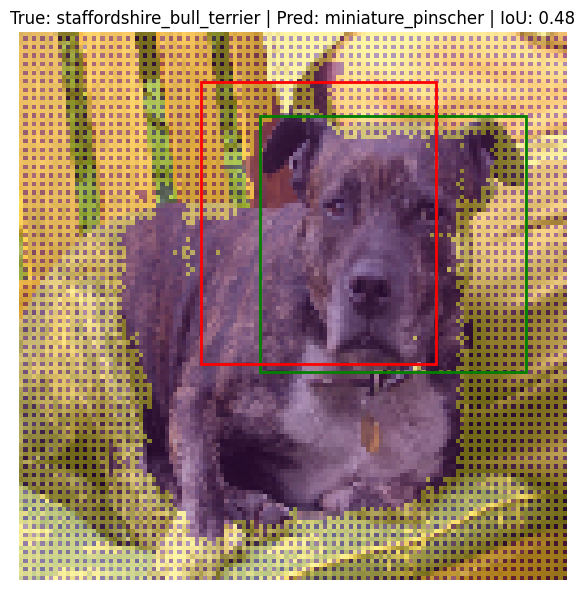

In [154]:
display_multitask_model(multitask_model, val_multitask_batches, 1)

## Display image with test sets

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


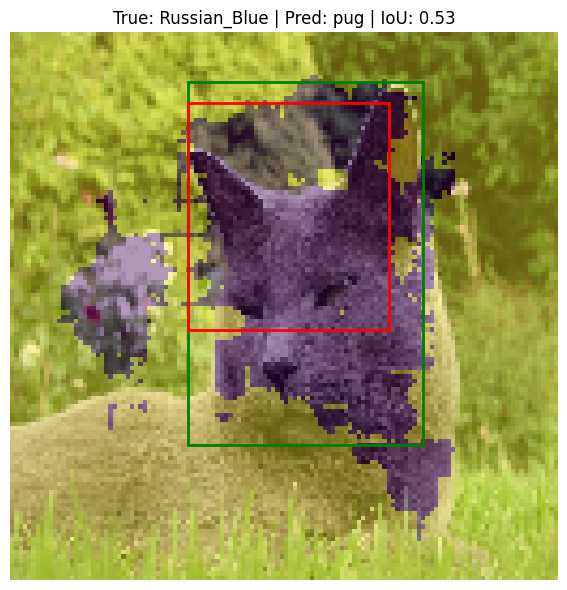

In [131]:
Multi_task_model = tf.keras.models.load_model("Multi-task-model-v2.keras",compile=False)
display_multitask_model(Multi_task_model, test_multitask_batches, 1)

## Plot train and val with base model 

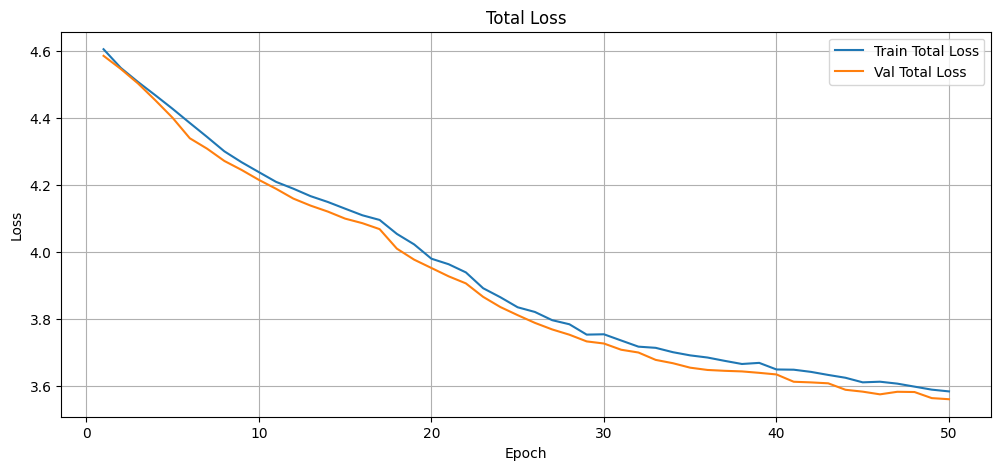

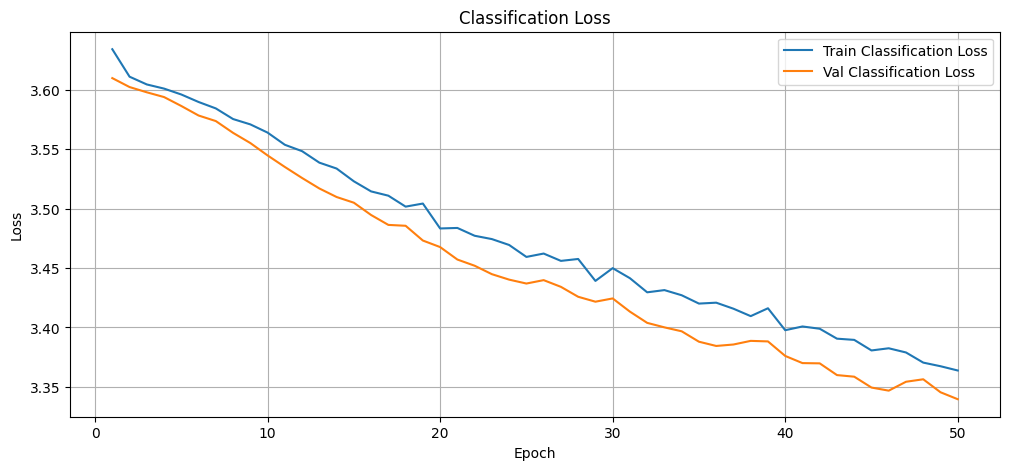

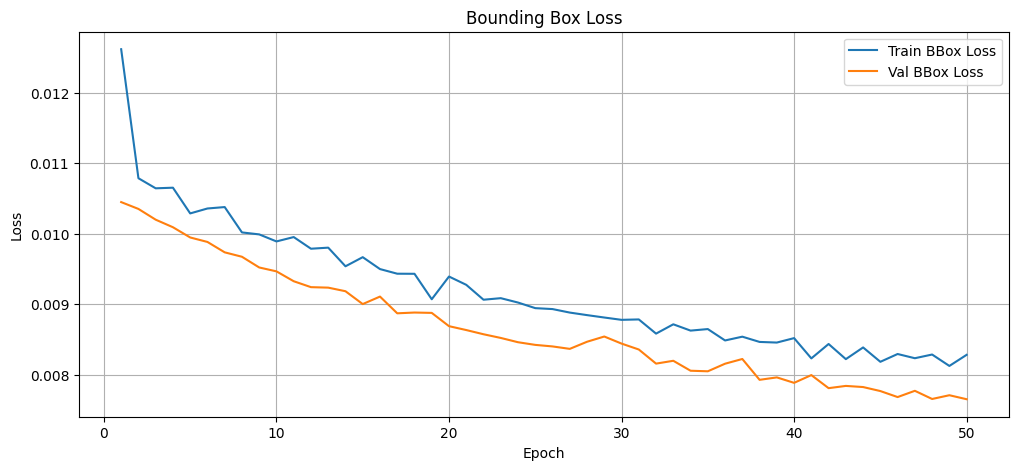

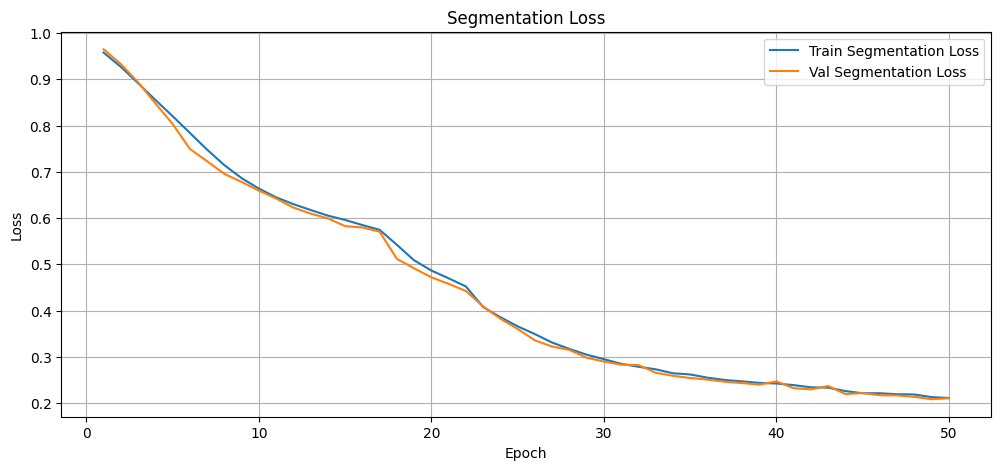

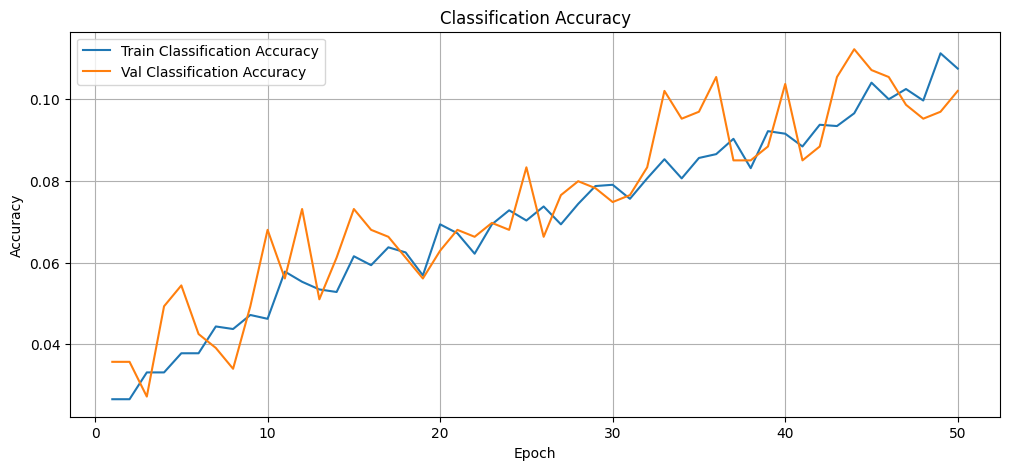

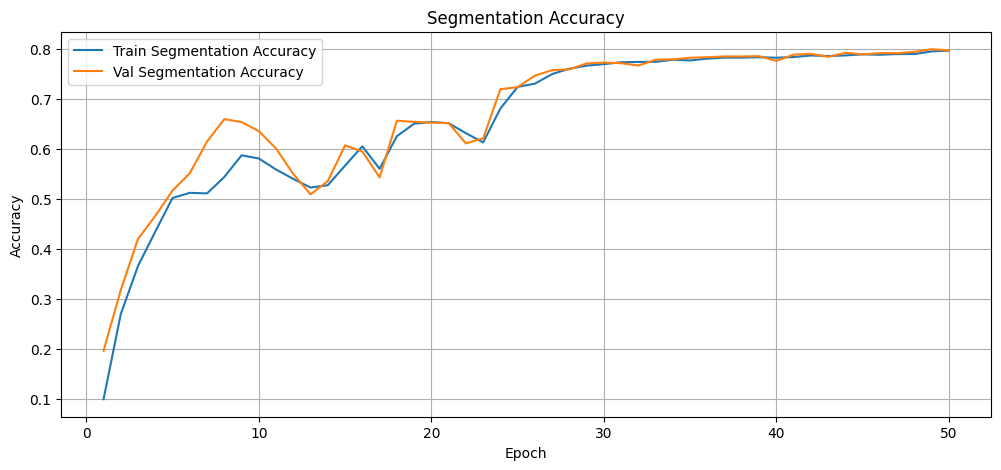

In [133]:
plot_multi_task(Multitask_Model)

## With pre-train weights: Using ResNet50

In [134]:
multitask_model_pretrain = multitask_model_resnet(input_shape=(128,128,3), output_channels=3, include_weights=True)
multitask_model_pretrain.summary()

Model: "functional_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_58            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_110            │ [(None, 64, 64, 64),   │     23,587,712 │ input_layer_58[0][0]   │
│ (Functional)              │ (None, 32, 32, 256),   │                │                        │
│                           │ (None, 16, 16, 512),   │                │                        │
│                           │ (None, 8, 8, 1024),    │                │                        │
│                           │ (None, 4, 4, 2048)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_44             │ (None, 8, 8, 512)      │      9,439,232 │ functional_110[0][4]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_32            │ (None, 8, 8, 1536)     │              0 │ sequential_44[0][0],   │
│ (Concatenate)             │                        │                │ functional_110[0][3]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_45             │ (None, 16, 16, 256)    │      3,539,968 │ concatenate_32[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_33            │ (None, 16, 16, 768)    │              0 │ sequential_45[0][0],   │
│ (Concatenate)             │                        │                │ functional_110[0][2]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_46             │ (None, 32, 32, 128)    │        885,248 │ concatenate_33[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_34            │ (None, 32, 32, 384)    │              0 │ sequential_46[0][0],   │
│ (Concatenate)             │                        │                │ functional_110[0][1]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ functional_110[0][4]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_47             │ (None, 64, 64, 64)     │        221,440 │ concatenate_34[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_35            │ (None, 64, 64, 128)    │              0 │ sequential_47[0][0],   │
│ (Concatenate)        

 Total params: 38,812,894 (148.06 MB)

 Trainable params: 15,223,230 (58.07 MB)

 Non-trainable params: 23,589,664 (89.99 MB)

In [135]:
alpha = 1.0
beta = 1.0

multitask_model_pretrain.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss= {
    "head_bbox": tf.keras.losses.Huber(),  # Smooth L1
    "class": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "segmentation_mask": tf.keras.losses.CategoricalCrossentropy(from_logits=True),},
    loss_weights={
    "head_bbox": alpha,
    "class": alpha,
    "segmentation_mask": beta,},
    metrics={
        "head_bbox": tf.keras.metrics.MeanAbsoluteError(),
        "class": tf.keras.metrics.SparseCategoricalAccuracy(),
        "segmentation_mask": tf.keras.metrics.CategoricalAccuracy(),})

In [136]:
multiTask_model_pretrain = multitask_model_pretrain.fit(
    train_multitask_batches,
    validation_data=val_multitask_batches,
    epochs=50,
    steps_per_epoch=100,
    callbacks=[early_stop, lr_schedule])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/framework/func_graph.py", line 1059, in func_graph_from_py_func
    func_outputs = python_func(*func_args, **func_kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 599, in wrapped_fn
    out = weak_wrapped_fn().__wrapped__(*args, **kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/polymorphic_function/autograph_util.py", line 41, in autograph_handler
    return api.converted_call(
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 339, in converted_call
    return _call_unconverted(f, args, kwargs, options)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11

TypeError: object of type 'NoneType' has no len()

## Display image with val sets - pretrain model

In [ ]:
display_multitask_model(Multi_task_pretrain, val_multitask_batches, 1)

## Display image with test data - pretrain model

In [ ]:
multitask_model_pretrain.save("Multi-task-model-pretrain.keras")
Multi_task_pretrain = tf.keras.models.load_model("Multi-task-model-pretrain.keras",compile=False)
display_multitask_model(Multi_task_pretrain, test_multitask_batches, 1)

## Plot train and val with pretrain model

In [ ]:
plot_multi_task(multiTask_model_pretrain)